In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
!python -m spacy download fr_core_news_sm
!python -m spacy download en_core_web_sm

import fr_core_news_sm, en_core_web_sm

spacy_fr = fr_core_news_sm.load()
spacy_en = en_core_web_sm.load()

     |████████████████████████████████| 14.7MB 1.2MB/s 
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.2.5-cp37-none-any.whl size=14727027 sha256=9decc995f950f1d7d56a460bf812fb1193893370153ec134c5ce928c38d777e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-sy8tahge/wheels/46/1b/e6/29b020e3f9420a24c3f463343afe5136aaaf955dbc9e46dfc5
Successfully built fr-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
def tokenize_fr(text):
    return [tok.text for tok in spacy_fr.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

SRC = Field(tokenize=tokenize_fr,
        init_token='<sos>',
        eos_token='<eos>',
        pad_token='<pad>',
        unk_token='<unk>',
        lower=True)

TRG = Field(tokenize=tokenize_en, 
            init_token='<sos>',
            eos_token='<eos>', 
            pad_token='<pad>',
            unk_token='<unk>',
            lower=True)

train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

training.tar.gz:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 5.19MB/s]
validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 1.43MB/s]

downloading validation.tar.gz
downloading mmt_task1_test2016.tar.gz



mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 1.32MB/s]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device,
    # memory 효율성 / 연산 속도 효율성을 위한 batch 길이 맞춰주기
    # pack padded sequence - pad packed sequence 랑 같이 쓸 수 있음
    sort_within_batch=True, 
    sort_key=lambda x: len(x.src))

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        # bidirection 때문에 enc_hid_dim * 2
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        # output은 가장 마지막의 hidden state, 즉 기존 seq2seq의 context vector와 동일
        # hidden 은 차례대로 layer 1 - forward / layer 1 - backward / ... layer n - forward / layer n - backward 순
        outputs, hidden = self.rnn(embedded)
        
        # foward / backward hidden state를 같이 고려할 수 있도록 설계함
        # 논문에서는 backward만 넣었다고 되어 있는데?
        # backward 를 넣는 것이 문장 전체에 대한 정확도를 높여주지 않을까? / RNN은 앞의 결과를 순차적으로 넣어주기 때문에?
        
        # option 1
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

        # option 2
        # 논문에서는 backward 만 사용했음
        # hidden = torch.tanh(hidden[-2, :, :])
        
        return outputs, hidden

In [ ]:
# badanau 식 attention 
# self-attention 이랑은 조금 다름
# attention을 학습하는 align neural network 를 jointly 학습시킨다는 특징이 있음

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        # 현재 상태에서 decoder는 하나 밖에 없으므로 전체 문장 길이만큼 반복해서 attention을 계산할 수 있도록 dimension을 맞춰줌
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        # encoder의 마지막 출력, 문장 전체에 대한 context를 내포. 
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        # 이후 batch matrix multiple 해야해서 batch를 앞으로 빼줌
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        attention = self.v(energy).squeeze(2)

        # 확률의 형태로 산출된 attention score
        return F.softmax(attention, dim=1)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)      
        embedded = self.dropout(self.embedding(input))
        # softmax를 거쳐서 만들어진 attention score
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        
        # decoder의 인풋과 weigth를 합쳐서 RNN의 input 값으로 취한다
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        return prediction, hidden.squeeze(0)

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5, is_train=True):
        self.is_train = is_train      
        src_length, batch_size = src.shape
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0,:]

        if self.is_train:     
            for t in range(1, trg_len):
                output, hidden = self.decoder(input, hidden, encoder_outputs)
                outputs[t] = output
                
                # input update / teacher forcing or moodel prediction
                # teacher forcing 은 exposure bias를 야기할 수 있음: infer 시 성능 저하 가능성
                # 최근 논문들은 pretrained model을 이용하는 방식이기 때문에 언어 모델에 overfitting 시킨다고 볼 수 있음.
                input = trg[t] if random.random() < teacher_forcing_ratio else output.argmax(1)
        elif not self.is_train:
            teacher_forcing_ratio = 0
            beam_size = 10

            # pad index == 3
            beam_outputs = torch.ones(trg_len, batch_size * beam_size, trg_vocab_size).to(self.device) * 3
            beam_length  = torch.zeros(batch_size * beam_size).to(self.device)
            outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

            # log softmax probabilities
            probs       = torch.zeros(batch_size * beam_size).to(self.device)
            log_softmax = nn.LogSoftmax(dim=0)

            encoder_outputs, hidden = self.encoder(src)
            input = trg[0, :]

            for beam in range(beam_size):
                beam_start_index = batch_size * beam 
                beam_end_index   = beam_start_index + batch_size
                end_counter = torch.BoolTensor(batch_size).zero_().to(self.device)

                for t in range(1, trg_len):
                    beam_output, hidden = self.decoder(input, hidden, encoder_outputs)
                    prob = log_softmax(beam_output).max(1)[0]

                    beam_outputs[t, beam_start_index:beam_end_index, :] = beam_output
                    probs[beam_start_index:beam_end_index] += prob
                    input = beam_output.squeeze().argmax(1)

                    end_counter += torch.eq(input, TRG.vocab.stoi['<eos>'])

                    if torch.all(end_counter):
                        beam_length[beam_start_index:beam_end_index] = t
                        break

            for batch in range(batch_size):
                beam_cand_index  = range(batch, beam_size * batch_size, batch_size)
                beam_output_cand = beam_outputs[:, beam_cand_index, :]

                # alpha = 1.2 / beta = 5 according to kh-kim's book
                # https://kh-kim.gitbooks.io/pytorch-natural-language-understanding/content/neural-machine-translation/beam-search.html
                length_penalty   = ((1 + beam_length[beam_cand_index]) ** 1.2) / ((1 + torch.ones(beam_size).to(self.device) * 5) ** 1.2)
                beam_prob_cand   = torch.mul(probs[beam_cand_index], length_penalty).to(self.device)
                
                print(beam_prob_cand)

                outputs[:, batch, :] = beam_output_cand[:, beam_prob_cand.argmax(0), :]

        return outputs

maxout은 아래와 같이 표현될 수 있다. ReLU와 leaky ReLU의 일반화 형태로 볼 수 있다고 한다. 

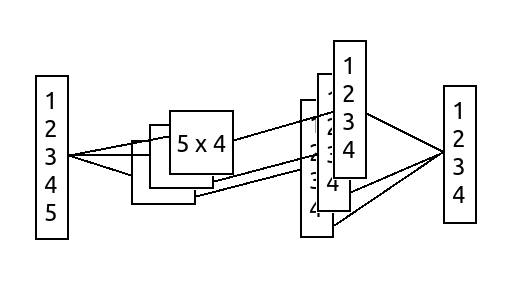

maxout 은 아래와 같이 구현할 수 있으며, 논문에서는 Decorder의 각 스텝마다 maxout을 적용했다고 언급하고 있다. 
[Pytorch Github Issues # 805](https://github.com/pytorch/pytorch/issues/805)

```python 
class Maxout(nn.Module):
    def __init__(self, d_in, d_out, pool_size):
        super().__init__()
        self.d_in, self.d_out, self.pool_size = d_in, d_out, pool_size
        self.lin = nn.Linear(d_in, d_out * pool_size)


    def forward(self, inputs):
        shape = list(inputs.size())
        shape[-1] = self.d_out
        shape.append(self.pool_size)
        max_dim = len(shape) - 1
        out = self.lin(inputs)
        m, i = out.view(*shape).max(max_dim)
        return m
```


In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, device).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        if 'encoder.rnn.weight' in name:
            nn.init.orthogonal_(param.data)
        elif 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

The model has 20,523,781 trainable parameters


In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()
        
        output = model(src, trg, teacher_forcing_ratio=0.7, is_train=True)
        output_dim = output.shape[-1]     
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)     
        optimizer.step()

        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            #turn off teacher forcing
            output = model(src, trg, teacher_forcing_ratio=0, is_train=False)
            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 1
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

tensor([-104.5612,   -2.8724,   -2.8681,   -2.8672,   -2.8671,   -2.8673,
          -2.8675,   -2.8678,   -2.8681,   -2.8683], device='cuda:0')
tensor([-119.3406,   -3.8496,   -3.8489,   -3.8500,   -3.8503,   -3.8505,
          -3.8506,   -3.8507,   -3.8509,   -3.8510], device='cuda:0')
tensor([-125.0199,   -3.7724,   -3.7812,   -3.7841,   -3.7834,   -3.7810,
          -3.7794,   -3.7782,   -3.7772,   -3.7765], device='cuda:0')
tensor([-111.0877,   -3.3141,   -3.3265,   -3.3294,   -3.3302,   -3.3303,
          -3.3304,   -3.3303,   -3.3303,   -3.3303], device='cuda:0')
tensor([-116.5811,   -3.6795,   -3.7242,   -3.7401,   -3.7467,   -3.7500,
          -3.7521,   -3.7535,   -3.7546,   -3.7555], device='cuda:0')
tensor([-132.5925,   -3.8915,   -3.9094,   -3.9153,   -3.9174,   -3.9183,
          -3.9189,   -3.9194,   -3.9198,   -3.9201], device='cuda:0')
tensor([-121.8694,   -3.6204,   -3.6229,   -3.6245,   -3.6254,   -3.6259,
          -3.6262,   -3.6264,   -3.6265,   -3.6266], device='c

In [ ]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')